## Figure 3

- Panel A: Accuracy for all plates
- Panel B: PR curves for all plates
- Panel C: Confusion matrix for all plates

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(arrow))
suppressPackageStartupMessages(library(RColorBrewer))

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘patchwork’ was built under R version 4.2.3”
Warning message:
“package ‘arrow’ was built under R version 4.2.3”
Warning message:
“package ‘RColorBrewer’ was built under R version 4.2.3”


## Set paths

In [2]:
figure_dir <- "../figures"
output_main_figure_3 <- file.path(
    figure_dir, "main_figure_3_model_eval.png"
)
results_dir <- file.path(
    "../../2.evaluate_model/model_evaluation_data/"
)

## Load in PR curve data

In [3]:
# Load data (includes optimization in this file)
PR_results_file <- file.path(results_dir, "precision_recall_final_model.parquet")

PR_results_df <- arrow::read_parquet(PR_results_file)

dim(PR_results_df)
head(PR_results_df)

[1] 35463699        4

precision,recall,plate,datasplit
<dbl>,<dbl>,<chr>,<chr>
0.5000000,1,all_plates,val
0.5000001,1,all_plates,val
0.5000001,1,all_plates,val
0.5000002,1,all_plates,val
0.5000002,1,all_plates,val
0.5000003,1,all_plates,val


### Update data frame to create new column for the data type (shuffled or final)

In [4]:
# Create new column for model using the datasplit prefix
PR_results_df <- PR_results_df %>%
  mutate(shuffled_type = ifelse(grepl("^shuffled_", datasplit), "TRUE", "FALSE"))

# Remove "shuffled_" prefix from datasplit column for plotting
PR_results_df <- PR_results_df %>%
  mutate(datasplit = sub("^shuffled_", "", datasplit))

# Rename "data splits for interpretation
PR_results_df <- PR_results_df %>%
  mutate(datasplit = recode(datasplit, "test" = "Test", "train" = "Train", "val" = "Val"))
  
dim(PR_results_df)
head(PR_results_df)

[1] 35463699        5

precision,recall,plate,datasplit,shuffled_type
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.5000000,1,all_plates,Val,FALSE
0.5000001,1,all_plates,Val,FALSE
0.5000001,1,all_plates,Val,FALSE
0.5000002,1,all_plates,Val,FALSE
0.5000002,1,all_plates,Val,FALSE
0.5000003,1,all_plates,Val,FALSE


### Generate per plate and all plates plots

Note: Do not run each plate figure due to plate naming bug

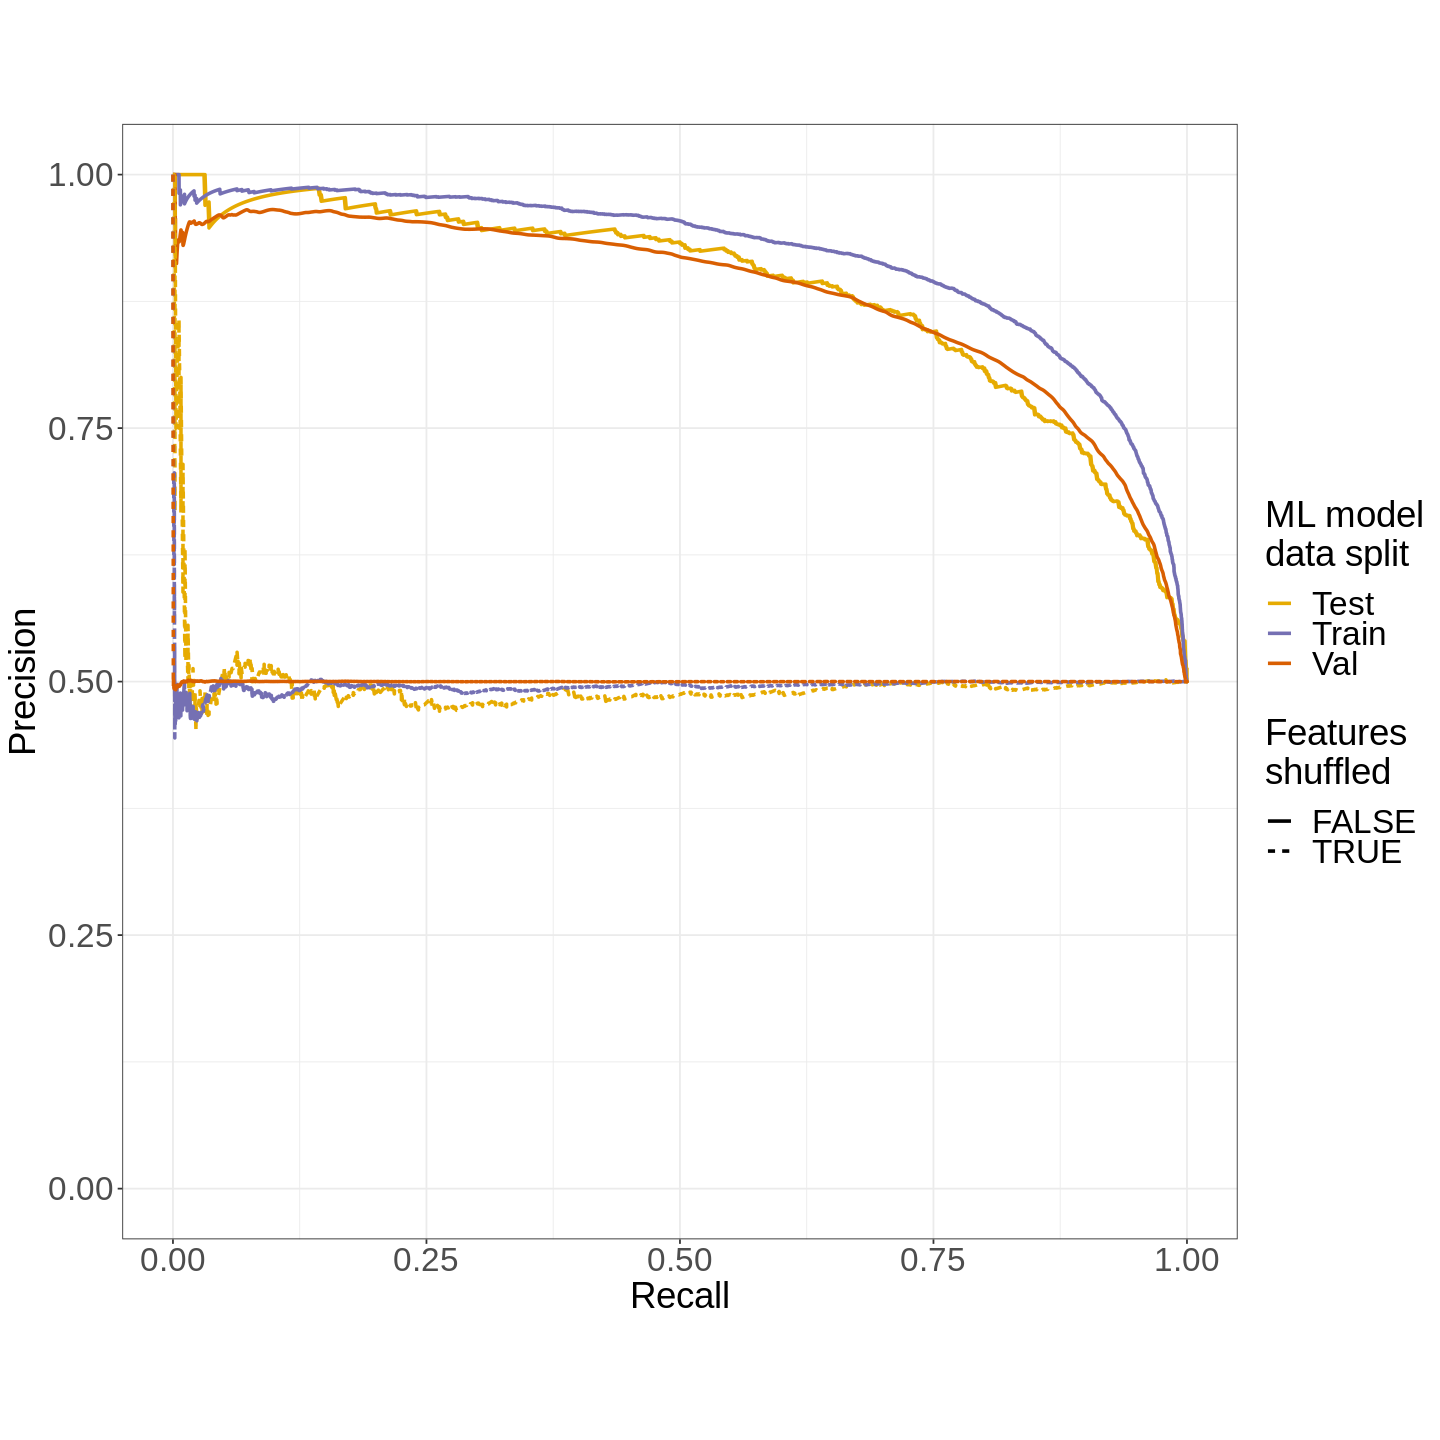

In [5]:
# Filter only rows with 'all_plates' in the 'plate' column
filtered_all_plates_pr_df <- PR_results_df[PR_results_df$plate == "all_plates", ]

width <- 12
height <- 12
options(repr.plot.width = width, repr.plot.height = height)
pr_all_plates_plot <- (
    ggplot(filtered_all_plates_pr_df, aes(x = recall, y = precision, color = datasplit, linetype = shuffled_type))
    + geom_line(aes(linetype = shuffled_type), linewidth = 1)
    + theme_bw()
    + coord_fixed()
    + labs(color = "ML model\ndata split", linetype = "Features\nshuffled", x = "Recall", y = "Precision")
    # change the colors
    + scale_color_manual(values = c(
        "Test" = brewer.pal(8, "Dark2")[6],
        "Train" = brewer.pal(8, "Dark2")[3],
        "Val" = brewer.pal(8, "Dark2")[2]
    ))
    + scale_y_continuous(limits = c(0, 1))
    # change the line thickness of the lines in the legend
    + guides(linetype = guide_legend(override.aes = list(size = 1)))  
    # change the text size
    + theme(
        # x and y axis text size
        axis.text.x = element_text(size = 20),
        axis.text.y = element_text(size = 20),
        # x and y axis title size
        axis.title.x = element_text(size = 22),
        axis.title.y = element_text(size = 22),
        # legend text size
        legend.text = element_text(size = 20),
        legend.title = element_text(size = 22),
    )
)

pr_all_plates_plot

## Load in metrics file (F1 scores and accuracy)

In [6]:
# Load data
metrics_results_file <- file.path(results_dir, "metrics_final_model.parquet")

metrics_results_df <- arrow::read_parquet(metrics_results_file)

# Filter out rows where datasplit is "val" or "shuffled_val"
metrics_results_df <- metrics_results_df %>%
    filter(!(datasplit %in% c("val", "shuffled_val")))

dim(metrics_results_df)
head(metrics_results_df)

[1] 16  6

f1_score,precision,recall,accuracy,plate,datasplit
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.8468692,0.8452019,0.8485430,0.8465665,all_plates,train
0.8835579,0.8782666,0.8889134,0.8828521,Plate_3,train
0.8510022,0.8872105,0.8176334,0.8568445,Plate_3_prime,train
0.7681645,0.7434011,0.7946346,0.7601758,Plate_5,train
0.4973174,0.4973455,0.4972894,0.4973458,all_plates,shuffled_train
0.4973568,0.4970284,0.4976857,0.4970245,Plate_3,shuffled_train


### Update data frame to create new column for the data type (shuffled or final)

In [7]:
# Create new column for model using the datasplit prefix
metrics_results_df$shuffled_type <- ifelse(grepl("^shuffled_", metrics_results_df$datasplit), "TRUE", "FALSE")

# Remove "shuffled_" prefix from datasplit column for plotting
metrics_results_df$datasplit <- sub("^shuffled_", "", metrics_results_df$datasplit)

# Rename "data splits for interpretation
metrics_results_df <- metrics_results_df %>%
  mutate(datasplit = recode(datasplit, "test" = "Test", "train" = "Train"))

dim(metrics_results_df)
head(metrics_results_df)

[1] 16  7

f1_score,precision,recall,accuracy,plate,datasplit,shuffled_type
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
0.8468692,0.8452019,0.8485430,0.8465665,all_plates,Train,FALSE
0.8835579,0.8782666,0.8889134,0.8828521,Plate_3,Train,FALSE
0.8510022,0.8872105,0.8176334,0.8568445,Plate_3_prime,Train,FALSE
0.7681645,0.7434011,0.7946346,0.7601758,Plate_5,Train,FALSE
0.4973174,0.4973455,0.4972894,0.4973458,all_plates,Train,TRUE
0.4973568,0.4970284,0.4976857,0.4970245,Plate_3,Train,TRUE


## Create plots for  all plates using accuracy

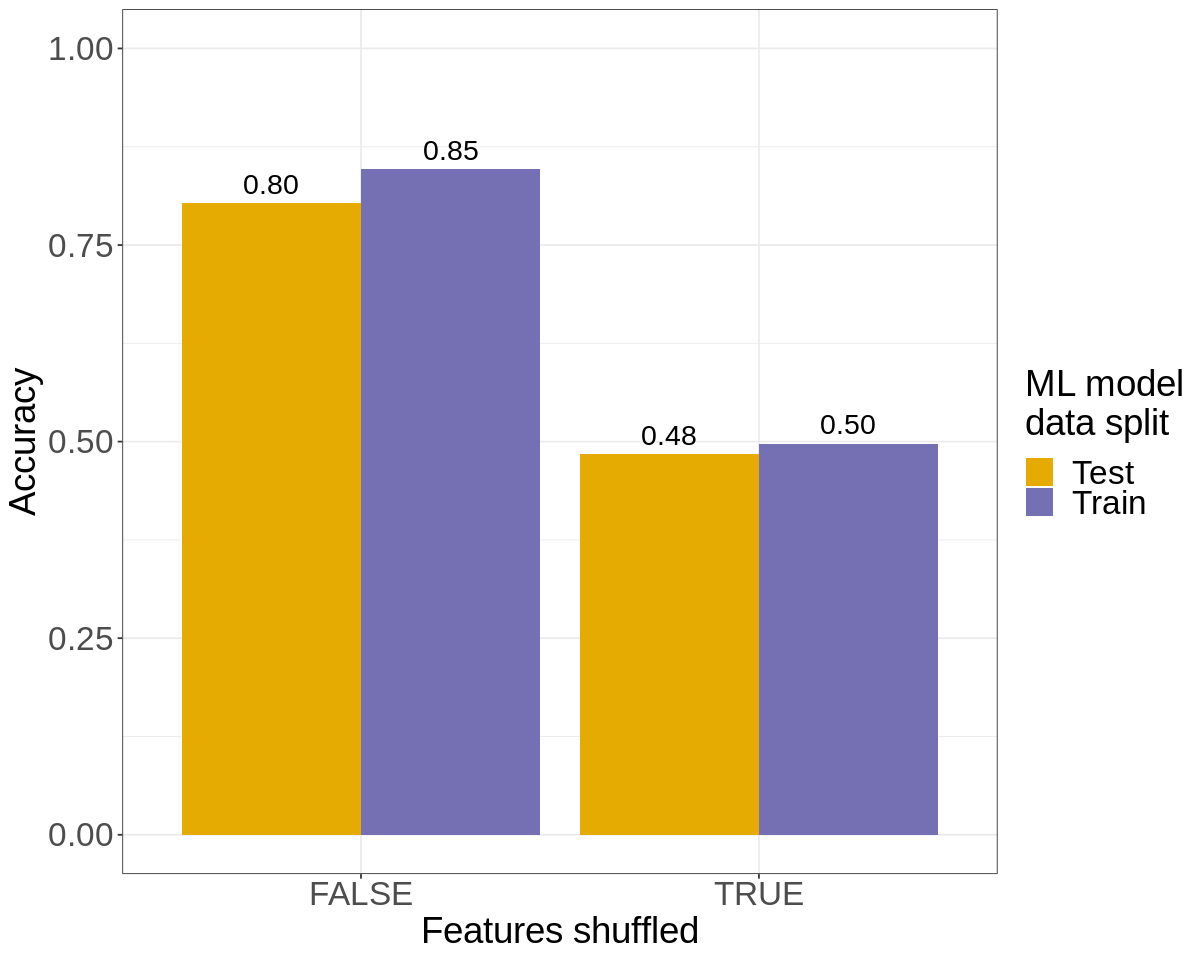

In [8]:
filtered_metrics_df <- metrics_results_df[metrics_results_df$plate == "all_plates", ]

width <- 10
height <- 8
options(repr.plot.width = width, repr.plot.height = height)
# bar plot of the accuracy scores
accuracy_score_all_plates_plot <- (
    ggplot(filtered_metrics_df, aes(x = shuffled_type, y = accuracy, fill = datasplit))
    + geom_bar(stat = "identity", position = "dodge")

    # Add text labels for accuracy scores on top of bars
    + geom_text(
        aes(label = sprintf("%.2f", accuracy)), 
        position = position_dodge(width = 0.9), 
        vjust = -0.5, 
        size = 6
    )

    + ylim(0, 1)
    + theme_bw()
    + ylab("Accuracy")
    + xlab("Features shuffled")
    # change the legend title
    + labs(fill = "ML model\ndata split")
    # change the colours
    + scale_fill_manual(values = c(
        "Test" = brewer.pal(8, "Dark2")[6],
        "Train" = brewer.pal(8, "Dark2")[3]
    ))
    # change the text size
    + theme(
        # x and y axis text size
        axis.text.x = element_text(size = 20),
        axis.text.y = element_text(size = 20),
        # x and y axis title size
        axis.title.x = element_text(size = 22),
        axis.title.y = element_text(size = 22),
        # legend text size
        legend.text = element_text(size = 20),
        legend.title = element_text(size = 22),
    )
)

accuracy_score_all_plates_plot

## Load in confusion matrix data

In [9]:
# Load data
CM_results_file <- file.path(results_dir, "confusion_matrix_final_model.parquet")

CM_results_df <- arrow::read_parquet(CM_results_file)

# Filter out rows where datasplit is "val" or "shuffled_val"
CM_results_df <- CM_results_df %>%
    filter(!(datasplit %in% c("val", "shuffled_val")))

dim(CM_results_df)
head(CM_results_df)

[1] 64  5

confusion_values,true_genotype,predicted_genotype,plate,datasplit
<int>,<chr>,<chr>,<chr>,<chr>
7478,Null,Null,all_plates,train
1376,Null,WT,all_plates,train
1341,WT,Null,all_plates,train
7513,WT,WT,all_plates,train
3978,Null,Null,Plate_3,train
559,Null,WT,Plate_3,train


### Update data frame to create new column for the data type (shuffled or final)

In [10]:
# Create new column for model using the datasplit prefix
CM_results_df$shuffled_type <- ifelse(grepl("^shuffled_", CM_results_df$datasplit), "TRUE", "FALSE")

# Remove "shuffled_" prefix from datasplit column for plotting
CM_results_df$datasplit <- sub("^shuffled_", "", CM_results_df$datasplit)

# Rename "data splits for interpretation
CM_results_df <- CM_results_df %>%
  mutate(datasplit = recode(datasplit, "test" = "Test", "train" = "Train"))

dim(CM_results_df)
head(CM_results_df)

[1] 64  6

confusion_values,true_genotype,predicted_genotype,plate,datasplit,shuffled_type
<int>,<chr>,<chr>,<chr>,<chr>,<chr>
7478,Null,Null,all_plates,Train,FALSE
1376,Null,WT,all_plates,Train,FALSE
1341,WT,Null,all_plates,Train,FALSE
7513,WT,WT,all_plates,Train,FALSE
3978,Null,Null,Plate_3,Train,FALSE
559,Null,WT,Plate_3,Train,FALSE


### Add ratio of confusion values to the total count

In [11]:
CM_results_df <- CM_results_df %>%
  dplyr::group_by(true_genotype, plate, datasplit, shuffled_type) %>%
  dplyr::mutate(
    total_count = sum(confusion_values),
    ratio = confusion_values / total_count
  )

dim(CM_results_df)
head(CM_results_df)

[1] 64  8

confusion_values,true_genotype,predicted_genotype,plate,datasplit,shuffled_type,total_count,ratio
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
7478,Null,Null,all_plates,Train,FALSE,8854,0.8445900
1376,Null,WT,all_plates,Train,FALSE,8854,0.1554100
1341,WT,Null,all_plates,Train,FALSE,8854,0.1514570
7513,WT,WT,all_plates,Train,FALSE,8854,0.8485430
3978,Null,Null,Plate_3,Train,FALSE,4537,0.8767908
559,Null,WT,Plate_3,Train,FALSE,4537,0.1232092


## Create confusion matrix plots for all plates

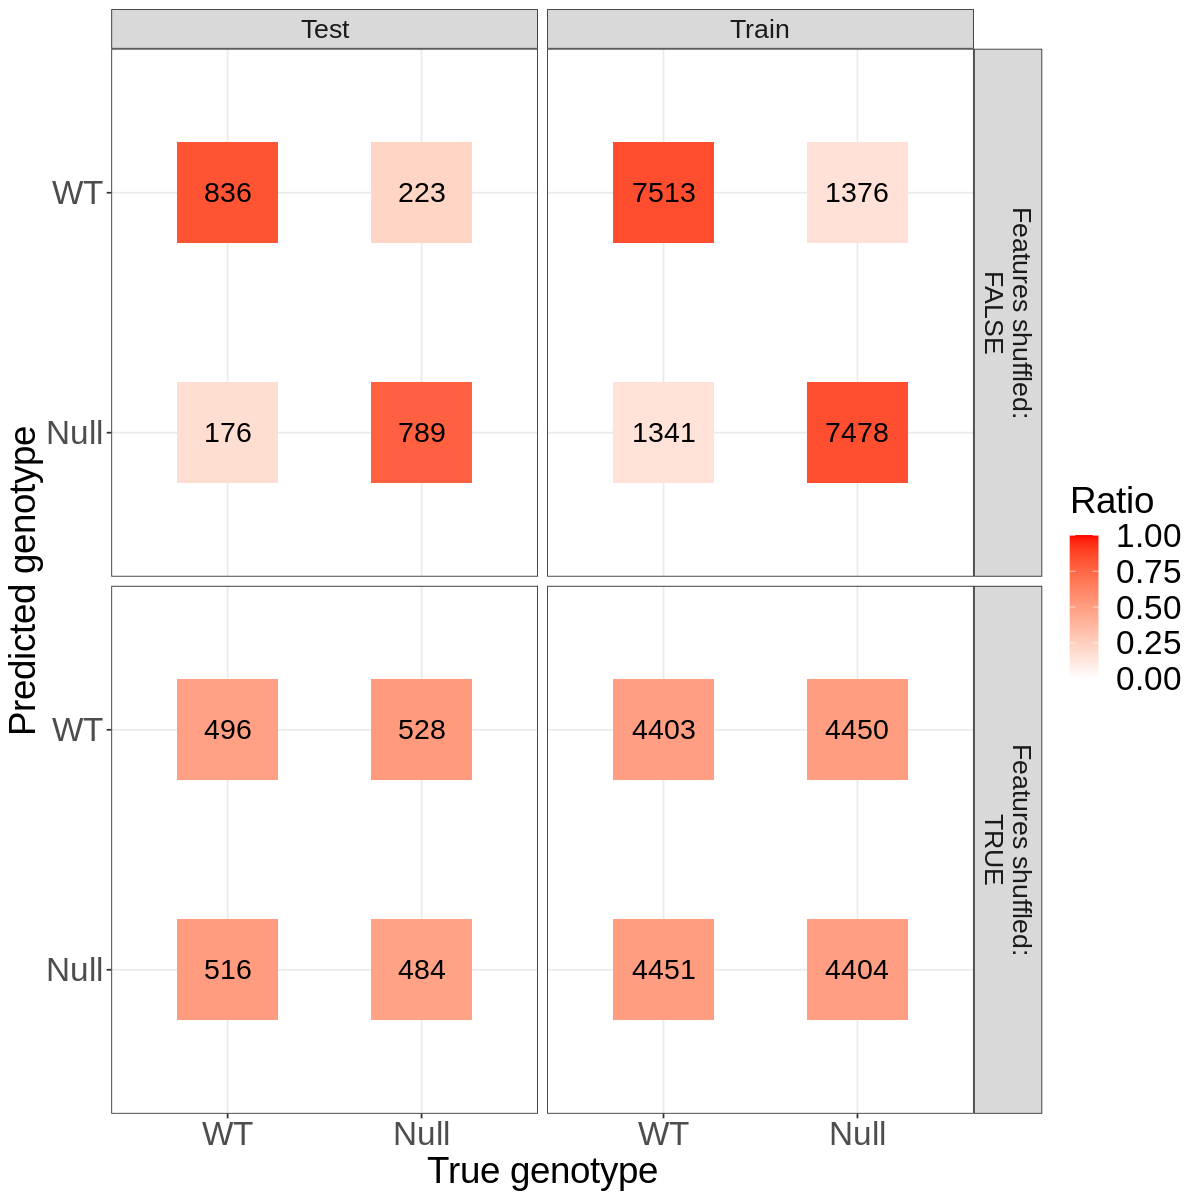

In [12]:
# Filter only rows with plate with "all_plates"
filtered_CM_df <- CM_results_df[(CM_results_df$plate == "all_plates"), ]

# plot dimensions
width <- 10
height <- 10
options(repr.plot.width = width, repr.plot.height = height)

# Custom labeller function
custom_labeller <- as_labeller(c(
  "Test" = "Test",
  "Train" = "Train",
  "FALSE" = "Features shuffled:\nFALSE",
  "TRUE" = "Features shuffled:\nTRUE"
))

# plot a confusion matrix
confusion_matrix_all_plates_plot <- (
    ggplot(filtered_CM_df, aes(x = factor(true_genotype, levels = rev(levels(factor(true_genotype)))), y = predicted_genotype)) +
    facet_grid(shuffled_type ~ datasplit, labeller = custom_labeller) +
    geom_point(aes(color = ratio), size = 28, shape = 15) +
    geom_text(aes(label = confusion_values), size = 6) +
    scale_color_gradient("Ratio", low = "white", high = "red", limits = c(0, 1)) +
    theme_bw() +
    ylab("Predicted genotype") +
    xlab("True genotype") +
    # change the text size
    theme(
        strip.text = element_text(size = 16),
        # x and y axis text size
        axis.text.x = element_text(size = 20),
        axis.text.y = element_text(size = 20),
        # x and y axis title size
        axis.title.x = element_text(size = 22),
        axis.title.y = element_text(size = 22),
        # legend text size
        legend.text = element_text(size = 20),
        legend.title = element_text(size = 22),
    )
)

confusion_matrix_all_plates_plot


## Create main figure 3 by patchworking plots together

In [13]:
align_plot <- (
    free(pr_all_plates_plot) |
    confusion_matrix_all_plates_plot |
    accuracy_score_all_plates_plot
) + plot_layout(widths = c(3,2,2))

In [14]:
fig_3_gg <- (
  align_plot
) + plot_annotation(tag_levels = "A") & theme(plot.tag = element_text(size = 25))

# Save the plot
ggsave(output_main_figure_3, plot = fig_3_gg, dpi = 500, height = 6, width = 22)